### "Шапка" с названием проекта

В этой ячейке вы найдете оглавление и ключевые этапы работы, которые помогут вам ориентироваться в процессе выполнения проекта. Проект разделен на пять основных этапов, четыре из которых (этапы 2, 3, 4 и 5) вам предлагается выполнить в этом Jupyter Notebook:

- Подготовка среды MLflow - Первый шаг, подготовка и запуск сервисов MLflow, был выполнен вне ноутбука и оформлен в виде shell скрипта. Это основа для работы с экспериментами и логирования результатов ваших моделей.

- Этап 2 - Исследовательский Анализ Данных (EDA): На этом этапе вы проведете тщательный анализ данных, чтобы лучше понять их структуру и особенности.

- Этап 3 - Генерация Признаков и Обучение Модели: После анализа данных вы сгенерируете новые признаки и обучите модель, используя эти признаки.

- Этап 4 - Отбор Признаков и Обучение Модели: На этом шаге вы отберете наиболее значимые признаки и снова обучите модель для улучшения ее качества.

- Этап 5 - Подбор Гиперпараметров и Обучение Финальной Версии Модели: Финальный этап проекта посвящен оптимизации гиперпараметров для достижения максимального качества модели.

Для удобства навигации и организации работы, пожалуйста, следуйте оглавлению и рекомендациям, описанным в каждом этапе.

> ### Важно: Переобучение моделей
> На каждом этапе проекта, где требуется переобучение модели, важно не просто выполнить эту процедуру, но и тщательно проверить качество модели на соответствующих выборках. Это включает в себя анализ метрик качества, визуализацию результатов, сравнение с предыдущими моделями и, при необходимости, корректировку.

> ### Важно: Разделение выборок
> Перед началом выполнения вашего проекта важно правильно подготовить данные, разделив их на подвыборки. Это позволит оценить производительность модели более объективно и управлять риском переобучения. В зависимости от ваших целей и доступных данных, вы можете использовать различные стратегии разделения:

1. Разделение на train/val/test: Это классический подход, где данные делятся на три части. Обучающая выборка (train) используется для первичного обучения моделей, валидационная (val) - для настройки гиперпараметров и выбора лучшей модели, а тестовая (test) - для финальной оценки производительности модели. Такой подход идеален, если у вас достаточно данных, чтобы разделить их и каждая из выборок была репрезентативна.

2. Разделение на train/test с кросс-валидацией на train: Если данных недостаточно для трех подвыборок, можно ограничиться разделением на обучающую и тестовую выборки. В этом случае кросс-валидация на обучающей выборке поможет оценить стабильность модели и подобрать гиперпараметры.

Определение способа разделения данных: Выбор метода разбиения данных на подвыборки — train, validation и test — должен быть обоснован особенностями вашего набора данных и задачами проекта. Возможные методы разделения, включая различные стратегии и правила, подробно описаны в [документации scikit-learn по разбиению данных](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py). Вы можете следовать этим примерам или разработать собственный метод, исходя из специфики ваших данных.

Ваша задача - выбрать подходящий метод разделения данных исходя из объема и специфики ваших данных. Помните, что финальные метрики качества модели мы будем оценивать на тестовой выборке. Промежуточные результаты после каждого этапа проекта (например, после настройки гиперпараметров) следует оценивать на валидационной выборке, если таковая имеется. Это поможет вам корректно настроить модель перед финальной оценкой её производительности.

In [1]:
# сделайте разделение изначального набора данных в этой ячейке
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import os
from autofeat import AutoFeatRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_validate
from catboost import CatBoostRegressor

ASSETS_DIR = "assets"

os.makedirs(ASSETS_DIR, exist_ok=True)

seed = 42

df = pd.read_csv('initial_data.csv')
X_train, X_test, y_train, y_test = train_test_split(df.drop('price',axis=1), df['price'], test_size=0.1, random_state=seed)


: 

In [2]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")


#### Этап 2: Исследовательский Анализ Данных (EDA)
На этом этапе ваша задача - провести тщательный исследовательский анализ данных (EDA), чтобы глубже понять особенности и связи в предоставленном наборе данных. В процессе EDA вы должны обратить внимание на три ключевых аспекта, о которых мы говорили в теме 3 курса. Очень важно, чтобы все результаты вашего исследования, включая визуализации, статистический анализ и предварительные выводы, были аккуратно залогированы в MLflow.

Для более организованного исследования предлагаем следующие рекомендуемые шаги:
- Понимание данных: Первоначально ознакомьтесь с данными, изучите типы данных, проверьте наличие пропущенных значений.
- Визуализация данных: Используйте графики и диаграммы для визуализации распределений признаков и возможных взаимосвязей между ними.
- Статистический анализ: Примените статистические методы для изучения центральных тенденций, разброса и корреляций между признаками.
- Предварительные выводы: На основе проведённого анализа сформулируйте предварительные выводы о данных, которые помогут в дальнейшем этапе моделирования.

Помните, что EDA - это итеративный процесс, в котором вы можете возвращаться к предыдущим шагам для дополнительного анализа, если это будет необходимо. Все находки и выводы должны быть чётко зафиксированы и легко доступны для команды проекта.


In [3]:
# 2.1 Загрузка данных

In [4]:
df = df.reset_index()

In [5]:
df.head()

,index,building_id,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,0,22315,4,7.8,17.6,1,False,False,34.299999,5350000.0,2013,2,55.504986,37.534801,2.70,660,17,True
1,1,24504,12,16.0,32.0,2,False,False,56.900002,9690000.0,2020,2,55.572639,37.485806,2.85,227,12,True
2,2,23303,3,12.4,33.0,2,False,False,53.799999,9200000.0,2016,2,55.573334,37.490517,3.00,264,12,True
3,3,22328,8,15.0,42.0,3,False,False,75.599998,12500000.0,2013,2,55.572762,37.483112,2.80,455,17,True
4,4,22288,1,11.0,25.0,1,False,False,41.000000,6300000.0,2013,1,55.567425,37.475487,2.80,245,12,True


In [6]:
# 2.2. Общий обзор датасета

In [6]:
df.isna().sum()

index                0
building_id          0
floor                0
kitchen_area         0
living_area          0
rooms                0
is_apartment         0
studio               0
total_area           0
price                0
build_year           0
building_type_int    0
latitude             0
longitude            0
ceiling_height       0
flats_count          0
floors_total         0
has_elevator         0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104095 entries, 0 to 104094
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              104095 non-null  int64  
 1   building_id        104095 non-null  int64  
 2   floor              104095 non-null  int64  
 3   kitchen_area       104095 non-null  float64
 4   living_area        104095 non-null  float64
 5   rooms              104095 non-null  int64  
 6   is_apartment       104095 non-null  bool   
 7   studio             104095 non-null  bool   
 8   total_area         104095 non-null  float64
 9   price              104095 non-null  float64
 10  build_year         104095 non-null  int64  
 11  building_type_int  104095 non-null  int64  
 12  latitude           104095 non-null  float64
 13  longitude          104095 non-null  float64
 14  ceiling_height     104095 non-null  float64
 15  flats_count        104095 non-null  int64  
 16  fl

In [8]:
df.describe()

,index,building_id,floor,kitchen_area,living_area,rooms,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total
count,104095.000000,104095.000000,104095.000000,104095.000000,104095.000000,104095.000000,104095.000000,1.040950e+05,104095.000000,104095.000000,104095.000000,104095.000000,104095.000000,104095.000000,104095.000000
mean,52047.000000,13504.084596,7.032855,8.378249,27.595582,1.948499,52.074677,1.192439e+07,1985.117710,3.491916,55.726589,37.600759,2.692437,243.147951,13.327509
std,30049.782473,6520.896811,4.914407,3.536494,14.506247,0.814888,16.527051,4.580951e+06,19.751087,1.410237,0.104199,0.149270,0.133727,170.087483,5.311246
min,0.000000,4.000000,1.000000,0.000000,0.000000,1.000000,11.000000,1.100000e+01,1902.000000,0.000000,55.427238,37.190201,2.450000,1.000000,1.000000
25%,26023.500000,8390.000000,3.000000,6.100000,19.000000,1.000000,38.500000,8.600000e+06,1969.000000,2.000000,55.646149,37.493713,2.640000,117.000000,9.000000
50%,52047.000000,13269.000000,6.000000,8.500000,28.500000,2.000000,49.700001,1.099000e+07,1981.000000,4.000000,55.715603,37.589050,2.640000,203.000000,12.000000
75%,78070.500000,19046.000000,10.000000,10.000000,36.000000,3.000000,61.400002,1.420000e+07,2003.000000,4.000000,55.813389,37.718697,2.740000,320.000000,17.000000
max,104094.000000,24620.000000,29.000000,102.000000,74.000000,7.000000,118.500000,2.840000e+07,2023.000000,6.000000,56.011032,37.946411,3.000000,4455.000000,29.000000


In [9]:
df.nunique()

index                104095
building_id           20885
floor                    28
kitchen_area            734
living_area            1408
rooms                     6
is_apartment              2
studio                    1
total_area             1838
price                  4097
build_year              115
building_type_int         7
latitude              14471
longitude             14112
ceiling_height           35
flats_count             693
floors_total             29
has_elevator              2
dtype: int64

In [10]:
# 2.3 Анализ признаков для модели

2025-02-07 12:59:32,121 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-07 12:59:32,130 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


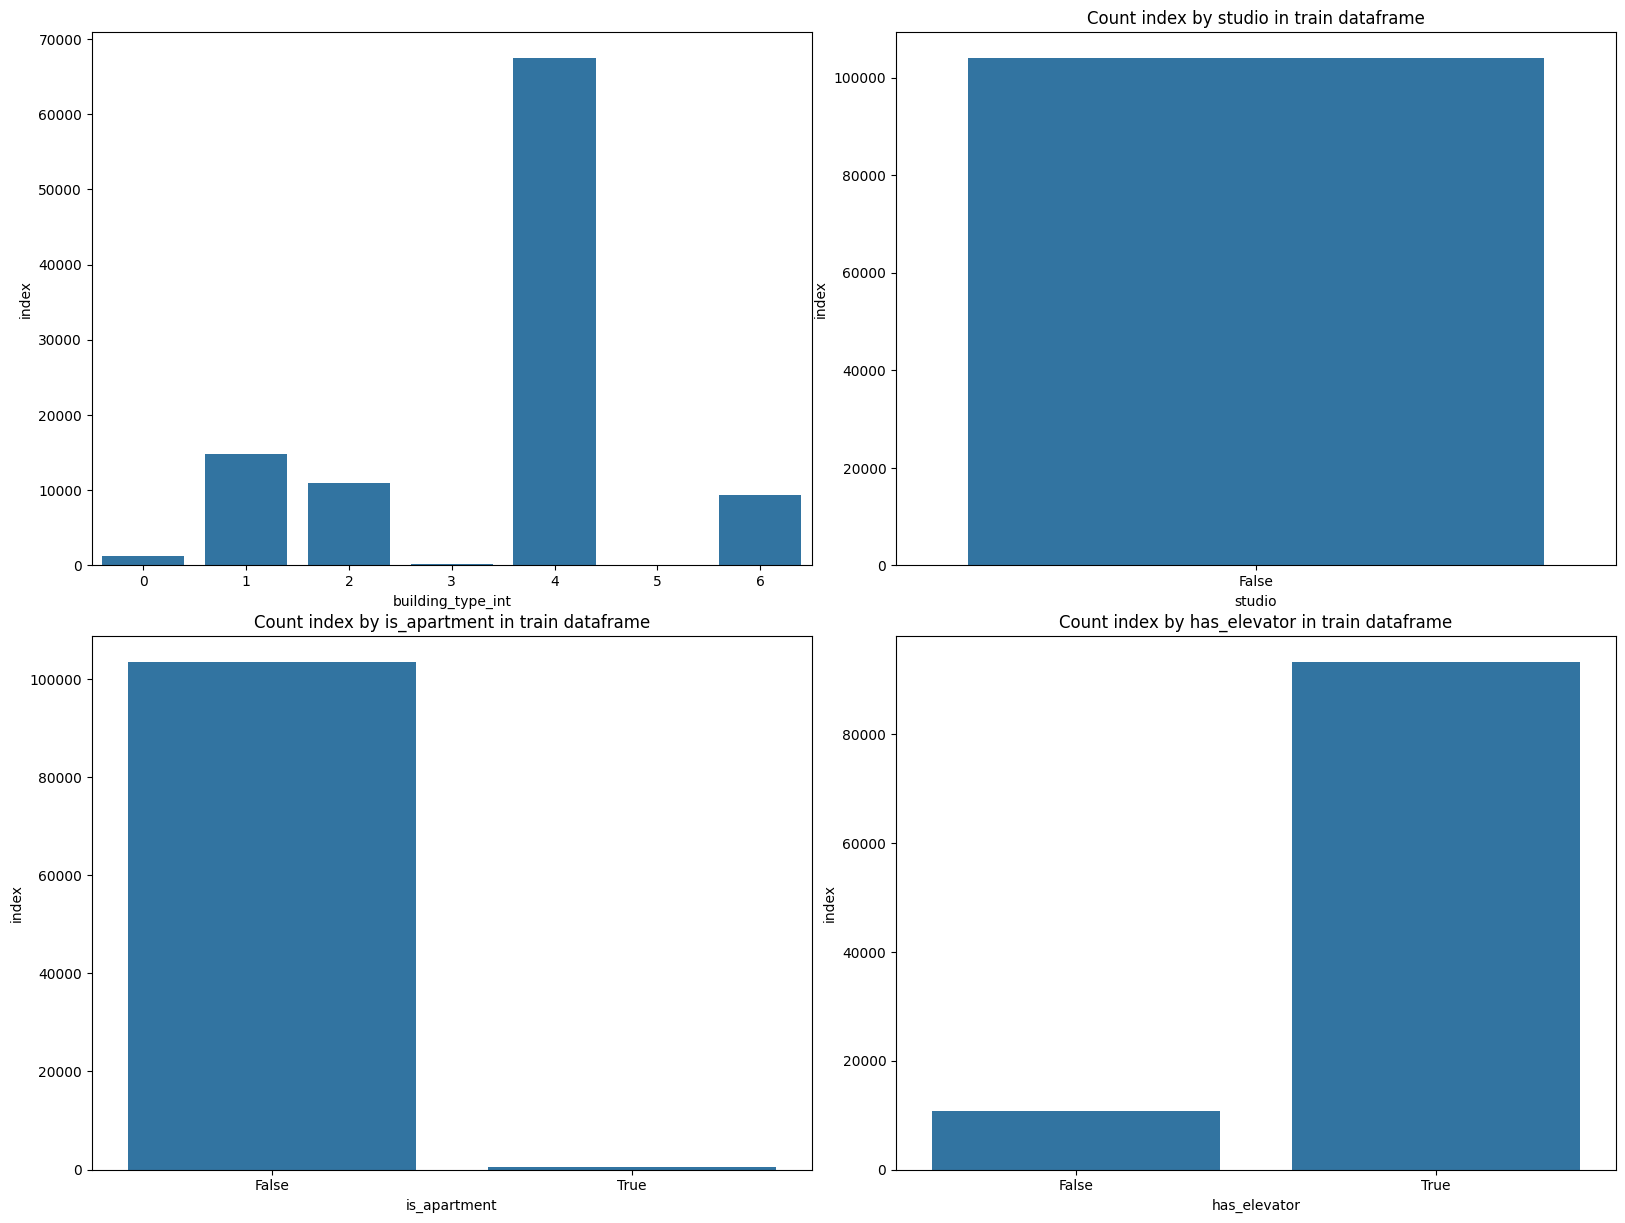

In [11]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=3)


x = "building_type_int"
y = "index"
stat = ["count"]
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 0])


x = "studio"
y = "index"
# ваш код тут #
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 1])
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')

x = "is_apartment"
y = "index"
# ваш код тут #
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 0])
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "has_elevator"
y = "index"
# ваш код тут #
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 1])
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1'))

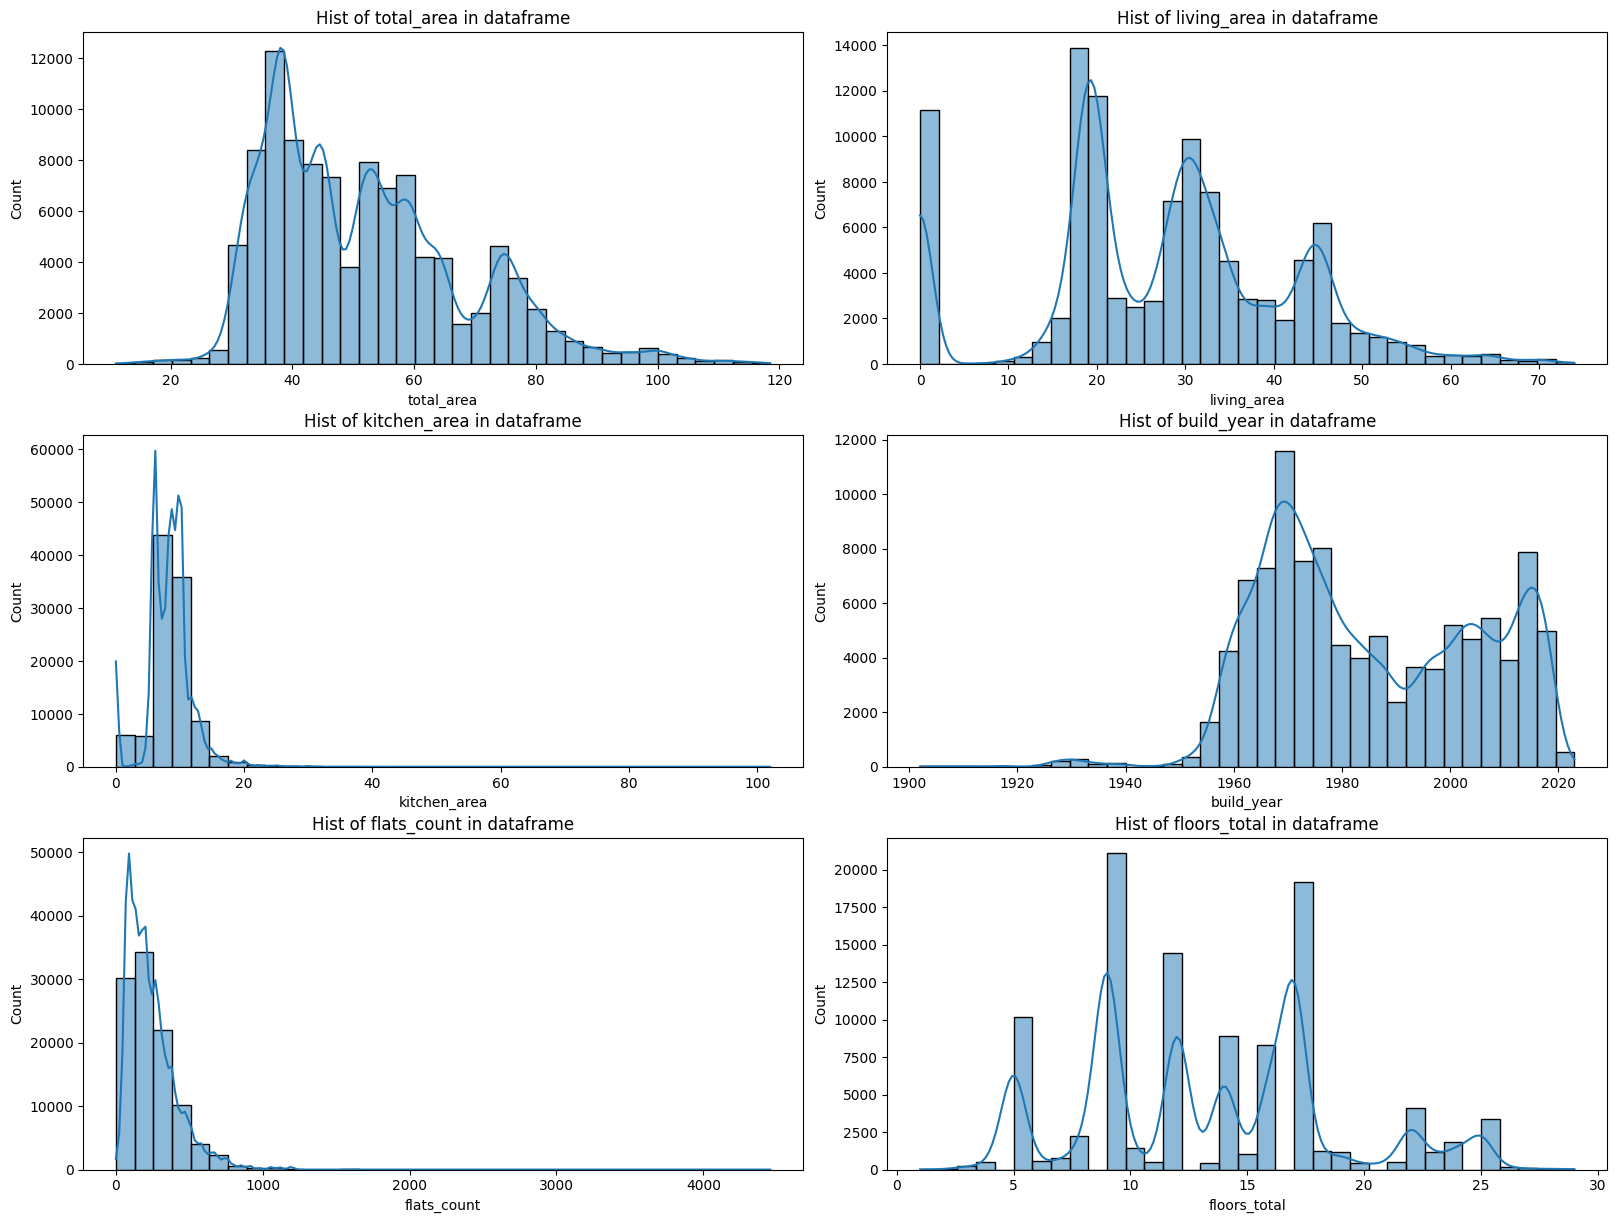

In [12]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=3)

x='total_area'
sns.histplot(data=df, x=x, kde=True, bins=35, ax=axs[0, 0])
axs[0, 0].set_title(f'Hist of {x} in dataframe')

x='living_area'
sns.histplot(data=df, x=x, kde=True, bins=35, ax=axs[0, 1])
axs[0, 1].set_title(f'Hist of {x} in dataframe')

x='kitchen_area'
sns.histplot(data=df, x=x, kde=True, bins=35, ax=axs[1, 0])
axs[1, 0].set_title(f'Hist of {x} in dataframe')

x='build_year'
sns.histplot(data=df, x=x, kde=True, bins=35, ax=axs[1, 1])
axs[1, 1].set_title(f'Hist of {x} in dataframe')

x='flats_count'
sns.histplot(data=df, x=x, kde=True, bins=35, ax=axs[2, 0])
axs[2, 0].set_title(f'Hist of {x} in dataframe')

x='floors_total'
sns.histplot(data=df, x=x, kde=True, bins=35, ax=axs[2, 1])
axs[2, 1].set_title(f'Hist of {x} in dataframe')

plt.savefig(os.path.join(ASSETS_DIR, 'num_features_dist'))

In [13]:
# 2.4 Анализ целевой переменной

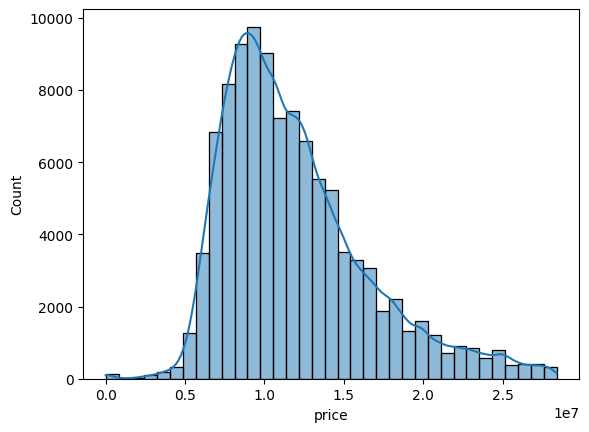

In [14]:
x='price'
sns.histplot(data=df, x=x, kde=True, bins=35)
plt.savefig(os.path.join(ASSETS_DIR, 'dist_of_target'))

In [15]:
df['price'].describe()

count    1.040950e+05
mean     1.192439e+07
std      4.580951e+06
min      1.100000e+01
25%      8.600000e+06
50%      1.099000e+07
75%      1.420000e+07
max      2.840000e+07
Name: price, dtype: float64

In [16]:
# 2.4 Анализ целевой переменной в зависимости от различных признаков

In [17]:
num_cols = ['price','total_area','living_area','kitchen_area','build_year','flats_count','floors_total'
           ,'rooms','ceiling_height','latitude','longitude']

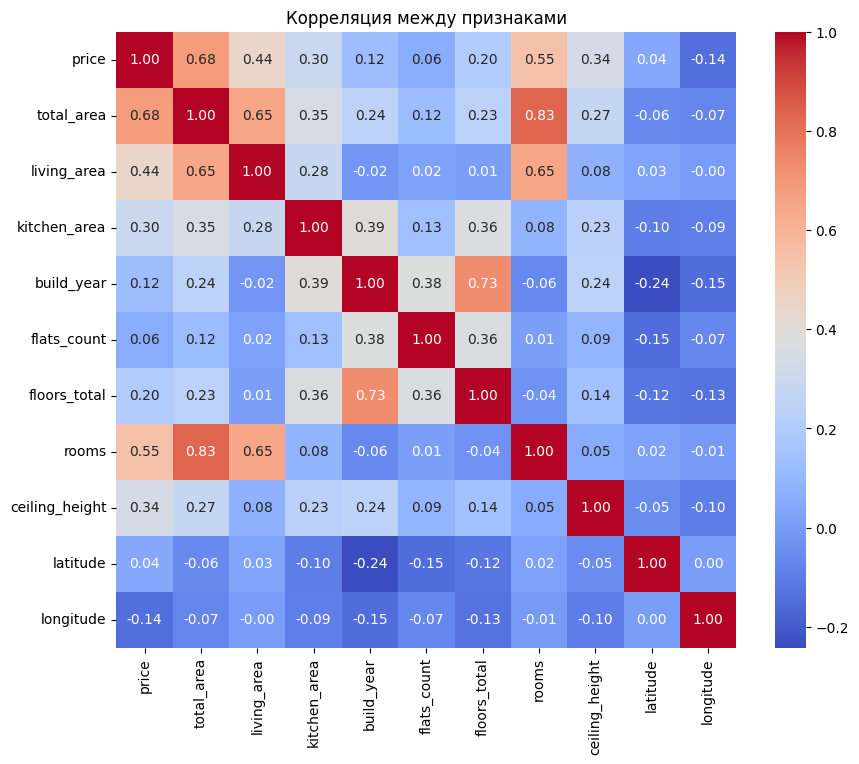

In [18]:
correlations_with_price = df[num_cols].corr()

# Построение тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(correlations_with_price, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция между признаками')

plt.savefig(os.path.join(ASSETS_DIR, 'corr_with_target'))

In [19]:
cat_and_bin_cols = ['is_apartment','has_elevator','building_type_int']

2025-02-07 12:59:38,864 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-07 12:59:38,920 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


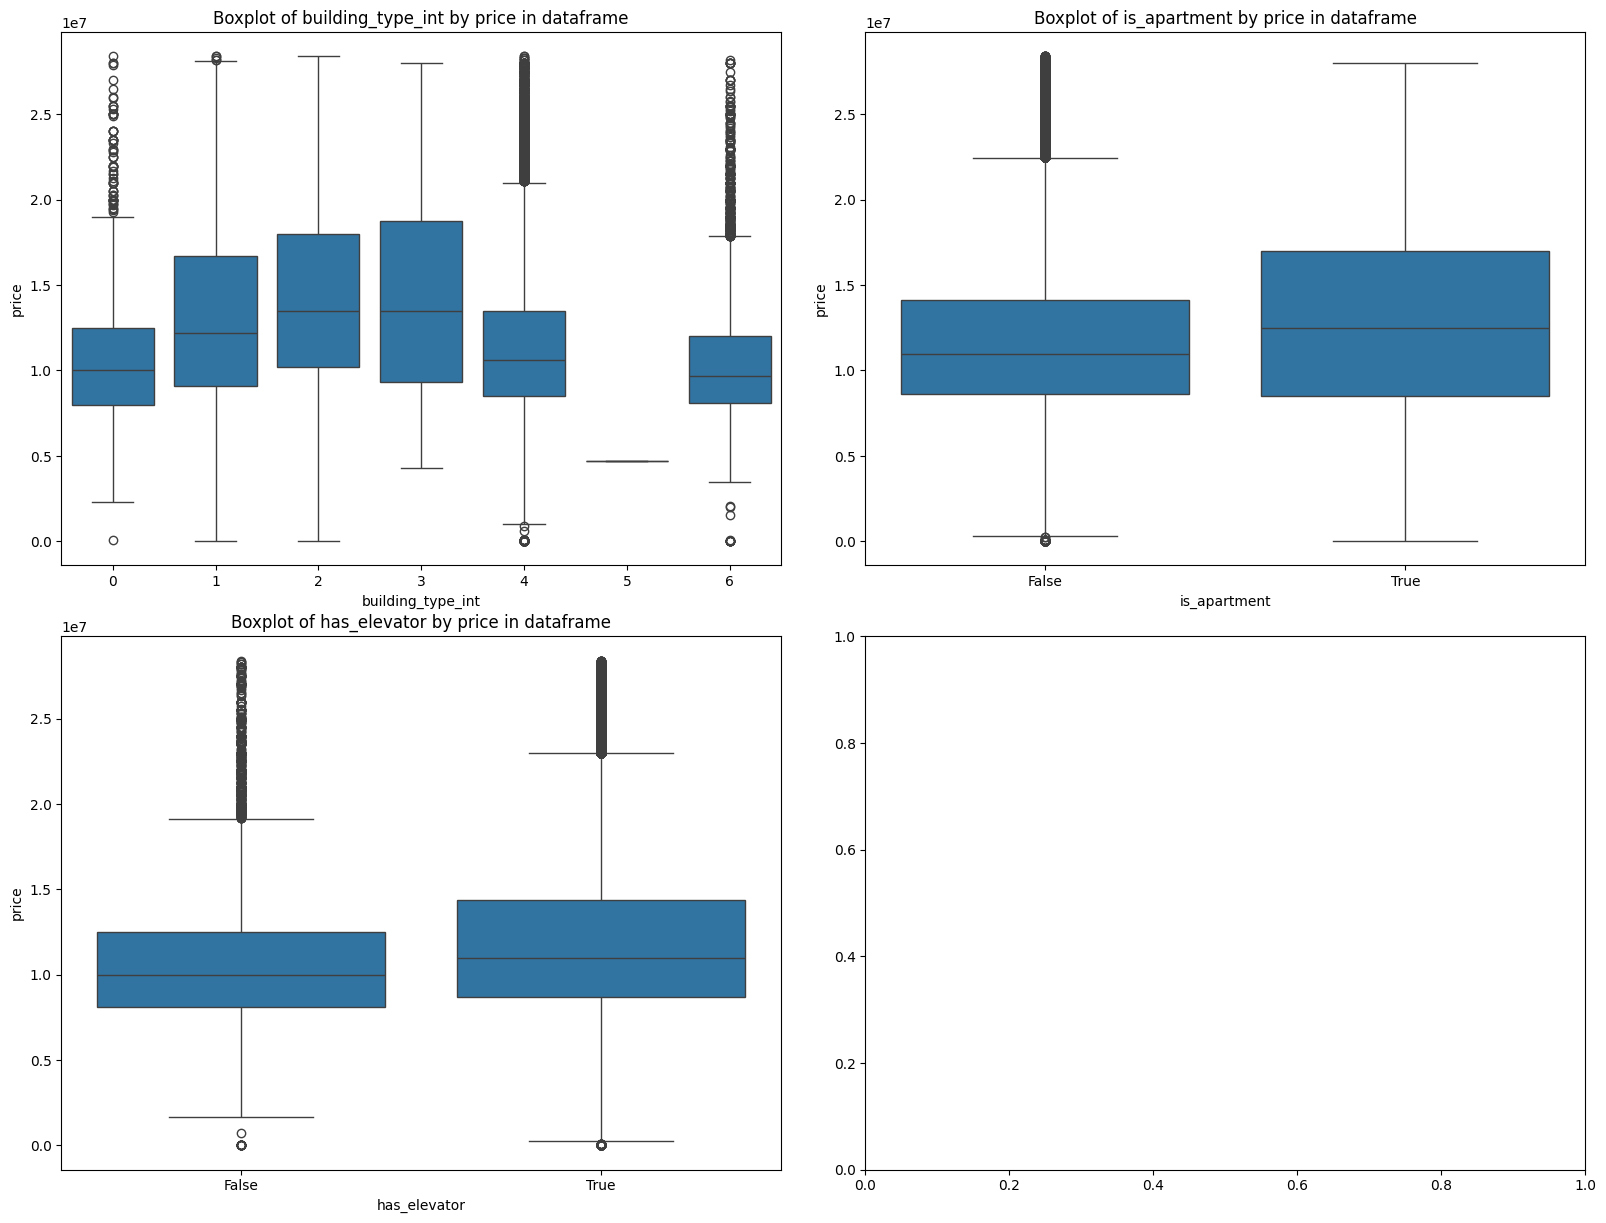

In [20]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=3)
y = "price"


x = 'building_type_int'
sns.boxplot(data=df, x=x, y=y, ax=axs[0, 0])
axs[0, 0].set_title(f'Boxplot of {x} by {y} in dataframe')

x = 'is_apartment'
sns.boxplot(data=df, x=x, y=y, ax=axs[0, 1])
axs[0, 1].set_title(f'Boxplot of {x} by {y} in dataframe')

x = 'has_elevator'
sns.boxplot(data=df, x=x, y=y, ax=axs[1, 0])
axs[1, 0].set_title(f'Boxplot of {x} by {y} in dataframe')

plt.savefig(os.path.join(ASSETS_DIR, 'price_boxplot_cat_bin_feats'))

In [22]:
# 2.5 Выводы после EDA

Данные на момент их использования моделью уже были отчищены от выбросов и не имеют пустых значений

Есть лишний признак только с одним значением:
studio

По ряду категориальных и бинарных признаков виден дисбаланс например:
building_type_int 
is_apartment 
has_elevator 

Все числовые признаки несмотря на удаление выбросов имеют тяжелые хвосты

Таргет наиболее "приближен" к нормальному распределению но тоже с тяжелыми хвостами и скосом в лево

Корреляционный анализ показывает что наиболее сильные признаки это признаки которые непосредственно касаются размера квартиры kitchen_area living_area ceiling_height total_area

Также разбивка таргета по категориальным и бинырным фичам boxplot показывает что между различными категориями есть разница в цене првада building_type_int = 5 имеет слишком мало значений чтобы его можно было анализировать

In [ ]:
# 2.6 логирование артефактов в MLflow

In [28]:
EXPERIMENT_NAME = "sprint2_model_price"
RUN_NAME = "save_stage_2_eda"

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR) 

#### Этап 3: Генерация Признаков и Обучение Новой Версии Модели
После тщательного исследовательского анализа данных (EDA), вы, скорее всего, сформировали несколько гипотез относительно новых признаков, которые могут улучшить качество вашей модели. На этом этапе, мы предлагаем вам приступить к генерации новых признаков и последующему обучению модели, используя два подхода:

Ручная генерация признаков: Используйте ваше понимание данных и результаты EDA для создания новых признаков.
Автоматическая генерация признаков: Воспользуйтесь библиотеками для автоматической генерации признаков, чтобы облегчить и ускорить этот процесс.
Важно: Для признаков, созданных вручную, рекомендуется использовать объекты sklearn, такие как Pipeline и ColumnTransformer. Это позволит автоматизировать процесс преобразования данных и облегчить поддержку вашего проекта.

После генерации новых признаков, наступает время обучить новую версию вашей модели, используя эти признаки. Не забудьте залогировать все результаты, включая новые признаки, параметры модели и метрики качества, в MLflow для удобства отслеживания изменений и результатов.

Рекомендуемые шаги:

- Определение и генерация новых признаков на основе ваших гипотез.
- Использование библиотек для автоматической генерации признаков, если это применимо.
- Интеграция новых признаков в вашу модель с помощью Pipeline или ColumnTransformer для ручно созданных признаков.
- Обучение новой версии модели с использованием всех доступных признаков.
- Логирование результатов в MLflow для документирования и анализа эффективности новых признаков и модели.

Этот этап проекта критически важен для повышения точности и эффективности вашей модели. Тщательная работа на этом этапе может существенно повлиять на итоговое качество моделирования.


In [ ]:
# 3.1 ручная генерация признаков

In [4]:
cat_cols = ['building_type_int']
bin_cols = ['is_apartment','has_elevator']
num_features = ['total_area','living_area','kitchen_area','build_year','flats_count','floors_total'
           ,'rooms','ceiling_height','latitude','longitude']

features = cat_cols + num_features + bin_cols

transformations = ("1/", "exp", "log","^2", "sin", "cos")

In [22]:
# 3.2 оборачивание всех преобразований в объекты sklearn

In [6]:
afc = AutoFeatRegressor(transformations=transformations, feateng_steps=1, n_jobs=-1)


In [24]:
# 3.3 автоматическая генерация признаков

In [27]:

preprocessor = ColumnTransformer(
        [
        ('binary', OneHotEncoder(drop='if_binary'), bin_cols),
        ('cat', CatBoostEncoder(return_df=False), cat_cols),
        ('num', StandardScaler(), num_features)
        ],
        remainder='drop',
        verbose_feature_names_out=False
        )

model = CatBoostRegressor(loss_function='RMSE')

pipeline = Pipeline(
[
    ('preprocessor', preprocessor),
    ('autofeat', afc),
    ('model', model)
]
)

cv_res = cross_validate(
    pipeline,
    df[features],
    df['price'],
    cv=5,
    n_jobs=2,
    scoring=['neg_root_mean_squared_error', 'r2','neg_mean_absolute_percentage_error']
    )

for key, value in cv_res.items():
    cv_res[key] = round(value.mean(), 3)  



Learning rate set to 0.082342
0:	learn: 4354447.3341423	total: 105ms	remaining: 1m 44s
1:	learn: 4166985.4617610	total: 152ms	remaining: 1m 15s
2:	learn: 3996081.0126465	total: 194ms	remaining: 1m 4s
3:	learn: 3845588.8620612	total: 241ms	remaining: 59.9s
4:	learn: 3714010.3335257	total: 289ms	remaining: 57.5s
5:	learn: 3596932.5528100	total: 329ms	remaining: 54.5s
6:	learn: 3492688.1919276	total: 376ms	remaining: 53.3s
7:	learn: 3398228.2973034	total: 420ms	remaining: 52s
8:	learn: 3315977.1505209	total: 466ms	remaining: 51.4s
9:	learn: 3245577.8250331	total: 492ms	remaining: 48.7s
10:	learn: 3180177.4827105	total: 520ms	remaining: 46.7s
11:	learn: 3121331.3283597	total: 543ms	remaining: 44.7s
12:	learn: 3066978.4702807	total: 567ms	remaining: 43s
13:	learn: 3018898.7173735	total: 589ms	remaining: 41.5s
14:	learn: 2975094.3071572	total: 612ms	remaining: 40.2s
15:	learn: 2937668.8204309	total: 636ms	remaining: 39.1s
16:	learn: 2905058.5178619	total: 662ms	remaining: 38.3s
17:	learn: 28

In [ ]:
# 3.4 обучение новой версии модели

In [28]:
pipeline.fit(X_train, y_train)

Learning rate set to 0.083889
0:	learn: 4366033.7900645	total: 73.7ms	remaining: 1m 13s
1:	learn: 4175745.4244753	total: 97.2ms	remaining: 48.5s
2:	learn: 4006251.3277198	total: 119ms	remaining: 39.6s
3:	learn: 3853387.3746688	total: 142ms	remaining: 35.5s
4:	learn: 3723092.7040631	total: 165ms	remaining: 32.9s
5:	learn: 3604204.4709307	total: 189ms	remaining: 31.3s
6:	learn: 3498615.9061571	total: 213ms	remaining: 30.3s
7:	learn: 3402412.1308747	total: 236ms	remaining: 29.2s
8:	learn: 3321136.7249563	total: 258ms	remaining: 28.4s
9:	learn: 3243089.1118564	total: 281ms	remaining: 27.8s
10:	learn: 3175963.3875075	total: 303ms	remaining: 27.2s
11:	learn: 3115407.0606402	total: 325ms	remaining: 26.8s
12:	learn: 3065703.2591347	total: 347ms	remaining: 26.3s
13:	learn: 3021632.1499844	total: 369ms	remaining: 26s
14:	learn: 2980081.6678429	total: 393ms	remaining: 25.8s
15:	learn: 2943147.8159833	total: 416ms	remaining: 25.6s
16:	learn: 2908106.6458516	total: 437ms	remaining: 25.3s
17:	learn:

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['is_apartment',
                                                   'has_elevator']),
                                                 ('cat',
                                                  CatBoostEncoder(return_df=False),
                                                  ['building_type_int']),
                                                 ('num', StandardScaler(),
                                                  ['total_area', 'living_area',
                                                   'kitchen_area', 'build_year',
                                                   'flats_count',
                                                   'floors_total', 'rooms',
                                                   'ceiling_height', 'latitude',
                                                   'longitude'])],
                                   verbose_feature_names_out=False)),
                ('autofeat',
                 AutoFeatRegressor(feateng_steps=1, n_jobs=-1,
                                   transformations=('1/', 'exp', 'log', '^2',
                                                    'sin', 'cos'))),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7f56b852bb50>)])

In [ ]:
# 3.5 логирование артефактов в MLflow

In [ ]:
EXPERIMENT_NAME = "sprint2_model_price"
RUN_NAME = "save_model_new_feats"
REGISTRY_MODEL_NAME = "model_price_appartment"

input_example =  df[features][:10]
prediction = pipeline.predict(input_example[:10])
signature = mlflow.models.infer_signature(input_example, prediction)

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_metrics(cv_res)
    
    model_info = mlflow.sklearn.log_model(
        pipeline, 
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        input_example=input_example,
        await_registration_for=60
		)

#### Этап 4: Отбор Признаков и Обучение Новой Версии Модели
Создание новых признаков — это лишь часть работы. Следующий важный шаг — это убедиться в том, что каждый из этих признаков действительно вносит положительный вклад в качество модели. Некоторые признаки могут оказывать отрицательное влияние на модель, поэтому их следует исключить из анализа.

На этом этапе, мы рекомендуем вам применить различные методы отбора признаков для того, чтобы определить и удалить те признаки, которые не улучшают качество вашей модели. Цель этого этапа — максимизировать производительность модели, удалив избыточные или неинформативные признаки.

После тщательного отбора признаков, пора обучить новую версию вашей модели, уже без негативно влияющих на неё признаков. Важно залогировать результаты этого этапа, включая измененный набор признаков, параметры модели и полученные метрики качества, в MLflow для последующего анализа и сравнения.

Рекомендуемые шаги:

- Применение методов отбора признаков для идентификации и исключения признаков, ухудшающих качество модели.
- Анализ влияния каждого признака на модель, чтобы понять, какие из них наиболее ценные.
- Обучение новой версии модели без негативно влияющих признаков.
- Логирование всех изменений и результатов в MLflow, включая конечный набор признаков, параметры модели и метрики качества.

Этот этап не только поможет улучшить качество вашей модели, но и даст глубокое понимание о важности и влиянии отдельных признаков на результаты моделирования.


In [ ]:
# 4.1 Отбор признаков при помощи метода номер 1

In [7]:
from mlxtend.feature_selection import SequentialFeatureSelector 


preprocessor = ColumnTransformer(
        [
        ('binary', OneHotEncoder(drop='if_binary'), bin_cols),
        ('cat', CatBoostEncoder(return_df=False), cat_cols),
        ('num', StandardScaler(), num_features)
        ],
        remainder='drop',
        verbose_feature_names_out=False
        )

pipeline_process = Pipeline(
[
    ('preprocessor', preprocessor),
    ('autofeat', afc),
]
)

In [ ]:
# 4.2 Отбор признаков при помощи метода номер 2

In [ ]:
# 4.3 Анализ отобранных признаков при помощи двух методов и формирование финального списка с признаками для модели

In [ ]:
# 4.4 Обучение новой версии модели

In [ ]:
# 4.5 Логирование всех артефактов в MLflow

### Этап 5 - подбор гиперпараметров и обучение новой версии модели
После того как мы уделили значительное внимание качеству модели через создание и отбор признаков, пришло время для финального штриха — подбора гиперпараметров. Этот этап является ключевым в финальной части проекта второго спринта, где ваша задача — оптимизировать гиперпараметры модели для достижения наилучшего качества.

Рекомендуется подобрать гиперпараметры как минимум двумя различными методами (например, с использованием Grid Search и Random Search), чтобы вы могли сравнить результаты и выбрать наиболее эффективный набор гиперпараметров для вашей модели. После определения оптимальных гиперпараметров, наступает время обучить финальную версию модели, используя ваши новые признаки.

Рекомендуемые шаги:

- Выбор методов для подбора гиперпараметров: Определитесь с методами, которые вы будете использовать для подбора гиперпараметров (например, Grid Search, Random Search, Bayesian Optimization).
- Подбор гиперпараметров: Примените выбранные методы для нахождения оптимальных значений гиперпараметров вашей модели.
- Сравнение результатов: Анализируйте и сравнивайте результаты, полученные различными методами, для определения наилучшего набора гиперпараметров.
- Обучение финальной модели: Используя выбранные гиперпараметры, обучите финальную версию вашей модели на новых признаках.
- Документирование процесса и результатов: Залогируйте все шаги и результаты в MLflow, включая сравнение методов подбора гиперпараметров и характеристики финальной модели.

Этот этап позволит вам максимально улучшить качество вашей модели перед финальной оценкой, предоставив полное понимание важности и влияния гиперпараметров на производительность модели.

In [ ]:
# 5.1 Подбор гиперпарметров при мощи метода номер 1

In [ ]:
# 5.2 Подбор гиперпарметров при мощи метода номер 2

In [ ]:
# 5.3 Формирование списка гиперпараметров для новой модели

In [ ]:
# 5.4 Обуение финальной версии модели

In [ ]:
# 5.5 Логирование артефактов в MLflow